In [1]:
#def xop2_2d(g, f, a0, a):
from tqdm import tqdm
from tools.operators import xop_2d, yop_2d, Discrete1DGrid, RHSswe, RK3, initialize_vortex
from tools.plotting import VisualizeGrid, coLocateVelocity, StartPlot, UpdatePlot, StartPlotEnergy, UpdatePlotEnergy
from tools.tests import StabilityCheck, calc_diagnostics
from tools.operators import RHS_AL81, RK3_AL81
import numpy as np
from matplotlib import pyplot as plt
import time

#### First Geometry - 80km resolution

In [2]:
#basin, resolution
xmin,xmax,N = 0, 3600000, 9
ymin,ymax,M = -1400000, 1400000, 7

# discretize x-y directions on a C-grid
xe,xc,dx = Discrete1DGrid(xmin,xmax,N)
ye,yc,dy = Discrete1DGrid(ymin,ymax,M)
xp,yp = np.meshgrid(xc,yc) # p-points
xu,yu = np.meshgrid(xe,yc) # u-points
xv,yv = np.meshgrid(xc,ye) # v-points
xz,yz = np.meshgrid(xe,ye) # z-points (vorticity)
dxs = np.array([dx,dy])    # grid size
# VisualizeGrid(xu,yu,xv,yv,xp,yp,xz,yz) # visualize grid optional
f0 = 9e-5
B = 1.8e-11
gravity = 0.081
depth = 0*np.ones([M,N])*np.sin((yp*np.pi*2)/2800000) * np.cos(((xp*np.pi*2)/2800000))*1000 + 1500
coriolis = f0 + B*yz

In [3]:
%matplotlib inline

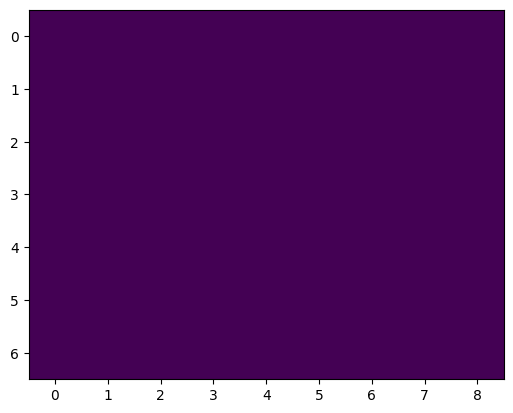

In [4]:
plt.imshow(depth)
plt.show()

In [5]:
%matplotlib

Using matplotlib backend: <object object at 0x00000178D6E77540>


In [6]:
plt.close('all')

### initial conditions


In [7]:
u,v,p = initialize_vortex(xu,xv,xp,yp,xz,yz,dxs[0], dxs[1],
                         gravity, coriolis, a=39.5061,
                         L = 200000,
                         x_center = 900000, y_center = 0)

In [8]:
u2,v2,p2 = initialize_vortex(xu,xv,xp,yp,xz,yz,dxs[0], dxs[1],
                         gravity, coriolis, a=39.5061,
                         L = 200000,
                         x_center = 900000, y_center = 0)

In [9]:
160*24*2600

9984000

In [10]:
periodic = False

alin = 1 # toggles between linear (0), nonlinear (1) PDEs
visc = .00
# tolerance = 10**-5
cell_area = dx*dy
ntimesteps = 160*24//4 #hourly = 169*24
isnap = 10       # frequency of visualization
finaltime = 160*24*2600
dt = finaltime/ntimesteps
StabilityCheck(gravity,depth,dt,dx)

max. Courant number: 0.28659029990563184
Stable gravity wave time step:


In [11]:
if periodic:
    u[:,0] = u[:,-2].copy()
    u[:,-1] = u[:,1].copy()
    v[:,0] = v[:,-2].copy()
    v[:,-1] = v[:,1].copy()
    p[:,0] = p[:,-2].copy()
    p[:,-1] = p[:,1].copy()

    u2[:,0] = u2[:,-2].copy()
    u2[:,-1] = u2[:,1].copy()
    v2[:,0] = v2[:,-2].copy()
    v2[:,-1] = v2[:,1].copy()
    p2[:,0] = p2[:,-2].copy()
    p2[:,-1] = p2[:,1].copy()

In [12]:
#reset indices for diagnostic calculations depending on BCs
if periodic:
    ind1u,ind2u = 1,-1
    ind1v,ind2v = 1,-1
    ind1p,ind2p = 1,-1
    ind1z,ind2z = 1,-1
else:
    ind1u, ind2u = 0, len(u[0,])
    ind1v ,ind2v = 0, len(v[0,])
    ind1p ,ind2p = 0, len(p[0,])
    ind1z ,ind2z = 0, len(coriolis[0,])

In [13]:
initial_energy, initial_enstrophy, initial_mass = calc_diagnostics(u[:,ind1u:ind2u],v[:,ind1v:ind2v],p[:,ind1p:ind2p],dxs,depth[:,ind1p:ind2p],gravity,coriolis[:,ind1z:ind2z],alin)

In [14]:
initial_energy2, initial_enstrophy2, initial_mass2 = calc_diagnostics(u2[:,ind1u:ind2u],v2[:,ind1v:ind2v],p2[:,ind1p:ind2p],dxs,depth[:,ind1p:ind2p],gravity,coriolis[:,ind1z:ind2z],alin)

### ADJUST P LEVS FOR PRESSURE CONTOURS


In [15]:
#set pmin manually since it drops slightly from beginning
plevs=np.linspace(-10,40,40)
xas,yas=4,4

In [16]:
fig,ax,pcont,arrows = StartPlot(u,v,p,xe,xc,ye,yc,plevs,XarrowStep=xas,YarrowStep=yas,arrow_scale=4 ,colormap='viridis')
ax.set_title('AX1')
plt.show()

In [17]:
fig2,ax2,pcont2,arrows2 = StartPlot(u2,v2,p2,xe,xc,ye,yc,plevs,XarrowStep=xas,YarrowStep=yas,arrow_scale=4 ,colormap='viridis')
ax2.set_title('AX2')
plt.show()

In [18]:
total_system_energy = [initial_energy]
total_system_enstrophy = [initial_enstrophy]
total_system_mass = [initial_mass]
times = [0.0]


total_system_energy2 = [initial_energy2]
total_system_enstrophy2 = [initial_enstrophy2]
total_system_mass2 = [initial_mass2]


In [19]:
for it in tqdm(range(ntimesteps)):
    timeCurrent = it*dt
    RK3_AL81(u,v,p,depth, coriolis, gravity, dxs, dt, timeCurrent, visc,bdc=0,tau_x=0,tau_y=0, alin=1,periodic=periodic)
    RK3(u2,v2,p2,depth, coriolis, gravity, dxs, dt, timeCurrent, visc,bdc=0,tau_x=0,tau_y=0, alin=1,periodic=periodic)
    if (it+1)%isnap==0:
        pcont = UpdatePlot(u,v,p    ,xe,xc,ye,yc,ax,pcont,plevs,timeCurrent+dt,arrows,XarrowStep=xas,YarrowStep=yas,colormap='viridis') # update numerical plot
        pcont2 = UpdatePlot(u2,v2,p2,xe,xc,ye,yc,ax2,pcont2,plevs,timeCurrent+dt,arrows2,XarrowStep=xas,YarrowStep=yas,colormap='viridis') # update numerical plot

        times.append(timeCurrent)
        eg, es, ms = calc_diagnostics(u[:,ind1u:ind2u],v[:,ind1v:ind2v],p[:,ind1p:ind2p],dxs,depth[:,ind1p:ind2p],gravity,coriolis[:,ind1z:ind2z],alin)
        total_system_energy.append(eg)
        total_system_enstrophy.append(es)
        total_system_mass.append(ms)
        
        eg, es, ms = calc_diagnostics(u2[:,ind1u:ind2u],v2[:,ind1v:ind2v],p2[:,ind1p:ind2p],dxs,depth[:,ind1p:ind2p],gravity,coriolis[:,ind1z:ind2z],alin)
        total_system_energy2.append(eg)
        total_system_enstrophy2.append(es)
        total_system_mass2.append(ms)

  0%|          | 0/960 [00:00<?, ?it/s]

100%|██████████| 960/960 [00:18<00:00, 51.97it/s]


In [20]:
plt.close('all')

In [21]:
%matplotlib inline

In [22]:
mass_plot = np.array(total_system_mass)/initial_mass
energy_plot = np.array(total_system_energy)/initial_energy
enstrophy_plot = (np.array(total_system_enstrophy) + 1)/(initial_enstrophy+1)

In [23]:
mass_plot2 = np.array(total_system_mass2)/initial_mass2
energy_plot2 = np.array(total_system_energy2)/initial_energy2
enstrophy_plot2 = (np.array(total_system_enstrophy2) + 1)/(initial_enstrophy2+1)

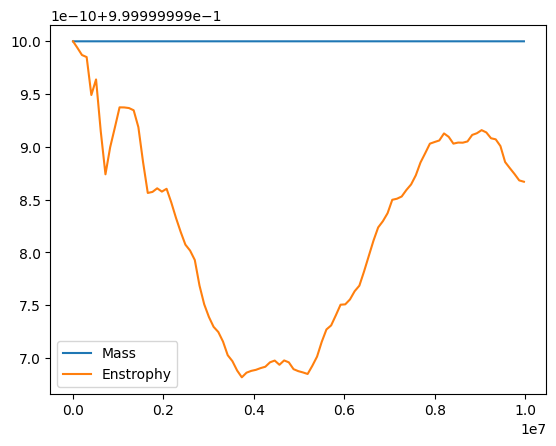

In [24]:
plt.plot(times,mass_plot, label='Mass')
# plt.plot(times,energy_plot, label='Energy')
plt.plot(times,enstrophy_plot, label='Enstrophy')
plt.legend()
plt.show()

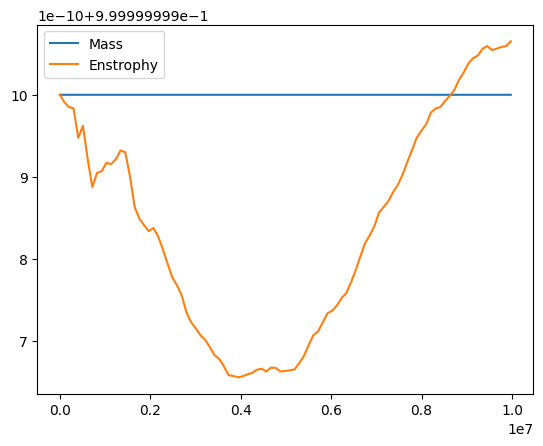

In [25]:
plt.plot(times,mass_plot2, label='Mass')
# plt.plot(times,energy_plot, label='Energy')
plt.plot(times,enstrophy_plot2, label='Enstrophy')
plt.legend()
plt.show()

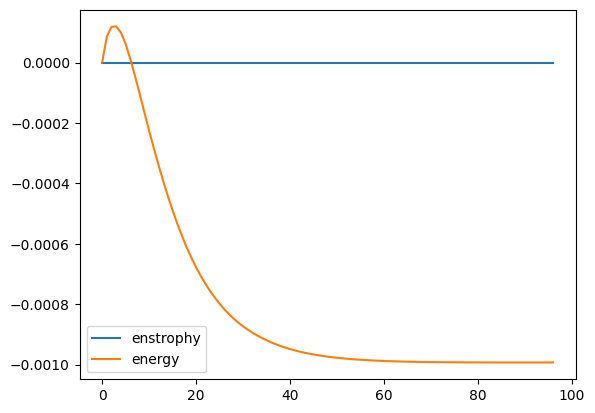

In [26]:
plt.plot(enstrophy_plot2-enstrophy_plot, label='enstrophy')
plt.plot(energy_plot2   -energy_plot, label='energy')
plt.legend()

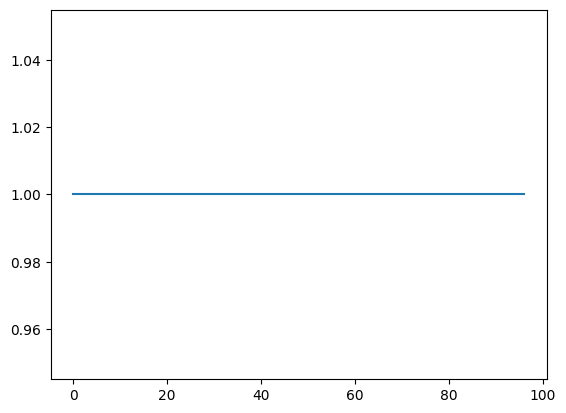

In [27]:
plt.plot(mass_plot)